# 作业3：前馈神经网络+自动微分

## 1. 数值稳定的算法

在编写激活函数或计算损失函数时，经常会遇到一些极端的取值，如果不对其进行适当的处理，很可能导致计算结果出现 `NaN` 或其他异常结果，影响程序的正常运行。本题将着重练习若干数值稳定的计算方法。

### 第1题

(a) 考虑 Sigmoid 函数 $$\sigma(x)=\frac{e^x}{1+e^x}$$

请利用 PyTorch 编写一个函数 `sigmoid(x)`，令其可以接收一个 Tensor `x`，返回 Sigmoid 函数在 `x` 上的取值。不可直接调用 `torch.sigmoid()`。

In [1]:
import numpy as np
import torch

def sigmoid(x):
    # 完成函数体
    e = torch.exp(-torch.abs(x))
    numer = torch.where(x>=0, 1.0, e)
    denom = 1.0 + e
    return numer / denom

一个简单的测试：

In [2]:
x = torch.tensor([-1000.0, -100.0, -10.0, 0.0, 10.0, 100.0, 1000.0])

# PyTorch 自带函数
print(torch.sigmoid(x))

# 上面编写的函数
print(sigmoid(x))

tensor([0.0000e+00, 0.0000e+00, 4.5398e-05, 5.0000e-01, 9.9995e-01, 1.0000e+00,
        1.0000e+00])
tensor([0.0000e+00, 3.7835e-44, 4.5398e-05, 5.0000e-01, 9.9995e-01, 1.0000e+00,
        1.0000e+00])


(b) 如果出现异常取值，思考可能的原因是什么。（提示：Sigmoid 函数真实的取值范围是多少？分子和分母的取值范围又是什么？是否可以对 Sigmoid 函数的表达式进行某种等价变换？）请再次尝试编写 Sigmoid 函数。如果一切正常，可忽略此问题。

### 第2题

(a) 考虑 Tanh 函数 $$\sigma(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}}$$

请利用 PyTorch 编写一个函数 `tanh(x)`，令其可以接收一个 Tensor `x`，返回 Tanh 函数在 `x` 上的取值。不可直接调用 `torch.tanh()`。

In [3]:
import numpy as np
import torch

def tanh(x):
    # 完成函数体、
    e = torch.exp(-torch.abs(2*x))
    numer = torch.where(x>=0, 1.0 - e, e - 1.0)
    denom = 1.0 + e
    return numer / denom

一个简单的测试：

In [4]:
x = torch.tensor([-1000.0, -100.0, -10.0, 0.0, 10.0, 100.0, 1000.0])

# PyTorch 自带函数
print(torch.tanh(x))

# 上面编写的函数
print(tanh(x))

tensor([-1., -1., -1.,  0.,  1.,  1.,  1.])
tensor([-1., -1., -1.,  0.,  1.,  1.,  1.])


(b) 如果出现异常取值，思考可能的原因是什么。请再次尝试编写 Tanh 函数。如果一切正常，可忽略此问题。

### 第3题

(a) 考虑 Softplus 函数 $$\mathrm{softplus}(x)=\log(1+e^x)$$

请利用 PyTorch 编写一个函数 `softplus(x)`，令其可以接收一个 Tensor `x`，返回 Softplus 函数在 `x` 上的取值。不可直接调用 `torch.nn.functional.softplus()`。

In [5]:
import torch

def softplus(x):
    # 完成函数体
    e = torch.exp(-torch.abs(x)) # e^(-x)
    log1e = torch.log(1 + e) # log(1+e)
    s_x = torch.where(x >= 0, x + log1e, log1e) # s(x) = log(1+e^x)
    return s_x

一个简单的测试：

In [6]:
x = torch.tensor([-1000.0, -100.0, -10.0, 0.0, 10.0, 100.0, 1000.0])

# PyTorch 自带函数
print(torch.nn.functional.softplus(x))

# 上面编写的函数
print(softplus(x))

tensor([0.0000e+00, 3.7835e-44, 4.5399e-05, 6.9315e-01, 1.0000e+01, 1.0000e+02,
        1.0000e+03])
tensor([0.0000e+00, 0.0000e+00, 4.5418e-05, 6.9315e-01, 1.0000e+01, 1.0000e+02,
        1.0000e+03])


(b) 如果出现异常取值，思考可能的原因是什么。请再次尝试编写 Softplus 函数。如果一切正常，可忽略此问题。

### 第4题

在作业2第2题中，为了计算损失函数，我们通常先计算 $\hat{\rho}=\mathrm{sigmoid}(X\beta)$，然后再与 $y$ 计算 $l(y,\hat{\rho})=-y\log \hat{\rho} - (1-y) \cdot \log(1-\hat{\rho})$。但当 $\hat{\rho}$ 非常接近0或1时，可能就会出现 $\log(0)$ 错误。根据本次作业第1题和第2题的结果，请思考是否有更稳定的数值算法，并重新编写损失函数。

In [7]:
def loss_fn_logistic(bhat, x, y):
    # 编写函数主体，替换这里的代码
    rho_x = torch.matmul(x, bhat) # rho(x) = XB
    s_x = softplus(rho_x)
    loss = -torch.mean(y * (rho_x - s_x) + (1 - y) * (-s_x))
    return loss

## 2. 自动微分

### 第5题

我们利用一个两层的前馈神经网络来模拟 XOR 函数。首先生成四个数据点：

In [8]:
x = torch.tensor([[0.0, 0.0],
                  [0.0, 1.0],
                  [1.0, 0.0],
                  [1.0, 1.0]])
y = torch.tensor([[0.0],
                  [1.0],
                  [1.0],
                  [0.0]])

可以看出输入的维度为 $p=2$，输出的维度为 $d=1$，样本量为 $n=4$。我们将构建一个两层的前馈神经网络，其中隐藏层的维度为 $r=5$。计算流程如下：

![](img/model.png)

$Z_1=XW_1+\mathbf{1}_nb_1^T,\quad A_1=\mathrm{softplus}(Z_1)$

$Z_2=A_1W_2+\mathbf{1}_nb_2^T,\quad A_2=\mathrm{sigmoid}(Z_2)$

其中 $\mathbf{1}_n$ 为元素全为1的 $n\times 1$ 向量，$W_1$ 为 $p\times r$ 矩阵，$b_1$ 为 $r\times 1$ 向量，$W_2$ 为 $r\times d$ 矩阵，$b_2$ 为 $d\times 1$ 向量。

先创建适当大小的 `w1`，`b1`，`w2` 和 `b2`，用标准正态分布填充，**并附加上梯度**（`requires_grad = True`）。

In [9]:
n = x.shape[0]  # 样本量
p = x.shape[1]  # 输入维度
d = y.shape[1]  # 输出维度
r = 5           # 隐藏层维度

# 完成此处程序
np.random.seed(123456)
torch.manual_seed(123456)
w1 = torch.randn(p, r, requires_grad = True)
b1 = torch.randn(r, requires_grad = True)
w2 = torch.randn(r, d, requires_grad = True)
b2 = torch.randn(d, requires_grad = True)

计算 `z1`，并确保结果的维度是正确的：

In [10]:
# 完成此处程序
# z1 = torch.matmul(x, w1) + torch.matmul(torch.ones(n, 1), b1.reshape(1, r))
z1 = torch.matmul(x, w1) + b1
assert z1.shape == (n, r), "z1 维度不正确"

利用前面编写的 `softplus` 函数计算 `a1`：

In [11]:
a1 = softplus(z1)

assert a1.shape == (n, r), "a1 维度不正确"

继续计算 `z2` 和 `a2`：

In [12]:
# 完成此处程序
z2 = torch.matmul(a1, w2) + b2
a2 = sigmoid(z2)

assert z2.shape == (n, d), "z2 维度不正确"
assert a2.shape == (n, d), "a2 维度不正确"

利用 Logistic 回归的损失函数，计算 $l(y,a_2)=-y\log(a_2)-(1-y)\log(1-a_2)$：

In [13]:
loss = -torch.mean(y * torch.log(a2) + (1.0 - y) * torch.log(1.0 - a2))
print(loss)

tensor(0.8125, grad_fn=<NegBackward0>)


利用反向传播计算出 `loss` 对 `w1`，`b1`，`w2` 和 `b2` 的梯度并打印出来：

In [14]:
loss.backward()
print(f"w1导数为 = {w1.grad}, \nb1导数为 = {b1.grad}, \nw2导数为 = {w2.grad}, \nb2导数为 = {b2.grad}")

w1导数为 = tensor([[ 0.0081, -0.0007, -0.1257,  0.0921,  0.0395],
        [ 0.0047,  0.0010,  0.0841,  0.0172, -0.0467]]), 
b1导数为 = tensor([ 0.0085,  0.0041, -0.0319,  0.0585,  0.0117]), 
w2导数为 = tensor([[ 0.2466],
        [ 0.0337],
        [-0.0303],
        [ 0.0873],
        [-0.0023]]), 
b2导数为 = tensor([0.0789])


## 3. 前馈神经网络

### 第6题

利用模块化编程（参考 `lec5-module.ipynb`），搭建一个第3题中的前馈神经网络，取隐藏层维度 $r=3$，拟合 XOR 函数。注意设置合适的步长和迭代次数，并打印出最终在 `x` 上的拟合值，与 `y` 的真值进行比较。模型类可以参考如下结构：

In [29]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MyModel, self).__init__()
        self.w1 = nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.b1 = nn.Parameter(torch.rand(hidden_dim, 1))
        self.w2 = nn.Parameter(torch.randn(hidden_dim, output_dim))
        self.b2 = nn.Parameter(torch.rand(output_dim, 1))

    def forward(self, x):
        # 完成此处程序
        z1 = torch.matmul(x, self.w1) + self.b1.reshape(1, r)
        a1 = softplus(z1)
        z2 = torch.matmul(a1, self.w2) + self.b2
        a2 = sigmoid(z2)
        return a2

np.random.seed(123456)
torch.random.manual_seed(123456)

r = 3
model = MyModel(input_dim=p, hidden_dim=r, output_dim=d)
print(list(model.parameters()))

[Parameter containing:
tensor([[ 1.8645,  0.4071, -1.1971],
        [ 0.3489, -1.1437, -0.6611]], requires_grad=True), Parameter containing:
tensor([[0.5524],
        [0.0060],
        [0.1053]], requires_grad=True), Parameter containing:
tensor([[ 0.8593],
        [-0.3097],
        [-0.9248]], requires_grad=True), Parameter containing:
tensor([[0.9038]], requires_grad=True)]


In [16]:
import matplotlib.pylab as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

iteration 0, loss = 1.1525518894195557
iteration 50, loss = 0.6369469165802002
iteration 100, loss = 0.5004288554191589
iteration 150, loss = 0.2696240544319153
iteration 200, loss = 0.12201838940382004
iteration 250, loss = 0.0642247349023819
iteration 300, loss = 0.0400487519800663
iteration 350, loss = 0.027927324175834656
iteration 400, loss = 0.020930727943778038
iteration 450, loss = 0.01647009886801243
iteration 500, loss = 0.013416093774139881
iteration 550, loss = 0.01121197547763586
iteration 600, loss = 0.009556141681969166
iteration 650, loss = 0.00827255379408598
iteration 700, loss = 0.007252415642142296
iteration 750, loss = 0.006424990948289633
iteration 800, loss = 0.005742515902966261
iteration 850, loss = 0.005171589553356171
iteration 900, loss = 0.004688276909291744
iteration 950, loss = 0.004274830687791109
[Parameter containing:
tensor([[ 4.8156,  1.3832, -4.3660],
        [ 1.9614, -1.9544, -5.4111]], requires_grad=True), Parameter containing:
tensor([[-2.7743],

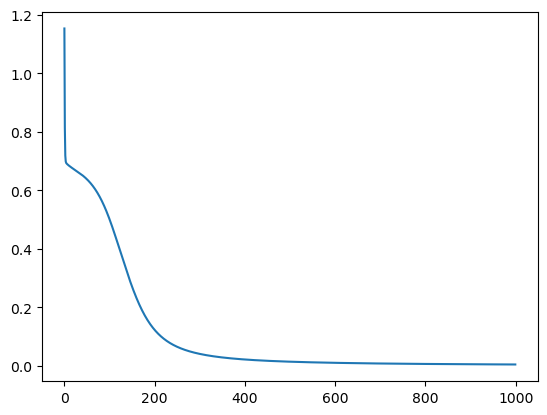

In [30]:
# 迭代次数
nepoch = 1000
# 学习率，即步长
learning_rate = 0.5
# 记录损失函数值
losses = []

opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

for i in range(nepoch):
    a2 = model(x)
    loss = -torch.mean(y * torch.log(a2) + (1.0 - y) * torch.log(1.0 - a2))

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())

    if i % 50 == 0:
        print(f"iteration {i}, loss = {loss.item()}")

print(list(model.parameters()))
plt.plot(losses)